In [1]:
%matplotlib inline
import sys, os
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['THEANO_FLAGS'] = 'device=cpu,compiledir_format="ipynb_compiledir_%(platform)s-%(processor)s-%(python_version)s-%(python_bitwidth)s"'
sys.path.append(os.getcwd()+"/..")

from tasks import check as load_filename
from scripts.imgtovideo import imgs_to_video
from data import load_data


import matplotlib.pyplot as plt
import numpy as np

import theano
import theano.tensor as T

from lasagne import layers as L

from lasagnekit.misc.plot_weights import dispims_color, tile_raster_images

from IPython.display import HTML, Image

import pandas as pd

from tqdm import tqdm

import base64
import json

from skimage.io import imread, imsave
from skimage.transform import resize

def load_model(filename, **kw):

    model = load_filename(
        what="notebook", 
        filename=filename, 
        **kw
    )
    return model

def build_brush_func(layers):
    if 'biased_output' in layers:
        bias = layers['biased_output'].b.get_value()
    elif 'bias' in layers:
        bias = layers['bias'].b.get_value()
    else:
        bias = np.array(0.1)

    bias = bias[np.newaxis, np.newaxis, :, np.newaxis, np.newaxis]

    if 'scaled_output' in layers:
        scale = layers['scaled_output'].scales.get_value()
    elif 'scale' in layers:
        scale = layers['scale'].scales.get_value()
    else:
        scale = np.array((1.,))
    scale = scale[np.newaxis, np.newaxis, :, np.newaxis, np.newaxis]

    
    X = T.tensor4()

    B = L.get_output(layers['brush'], X)
    if len(layers['brush'].output_shape) == 4: # (ex, t, w, h)
        B = B.dimshuffle(0, 1, 'x', 2, 3)
    
    fn = theano.function(
        [X], 
        T.nnet.sigmoid(B * scale + bias)
    )
    return fn

def build_encode_func(layers):
    w = layers['output'].output_shape[2]
    X = T.tensor4()
    fn = theano.function(
        [X], 
        T.nnet.sigmoid(L.get_output(layers['coord'], X)[:, :, 0:2]) * w
    )
    return fn

def to_grid_of_images(seq_imgs, **kw):
    y = seq_imgs
    imgs = []
    for t in range(y.shape[1]):
        yy = y[:, t]
        if yy.shape[1] == 1:
            yy = yy[:, 0, :, :, np.newaxis] * np.ones((1, 1, 1, 3))
        else:
            yy = yy.transpose((0, 2, 3, 1))
        img = dispims_color(yy, **kw)
        imgs.append(img)
    return imgs

def seq_to_video(seq, filename='out.mp4', verbose=1, framerate=8, rate=8, **kw):
    # shape of seq should be : (examples, time, c, w, h)
    seq = to_grid_of_images(seq, **kw)
    seq = [np.zeros_like(seq[0])] + seq
    if os.path.exists(filename):
        os.remove(filename)
    imgs_to_video(seq, out=filename, verbose=verbose, framerate=framerate, rate=rate)

def embed_video(filename):
    video = open(filename, 'r+b').read()
    encoded = base64.b64encode(video)
    return HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                </video>'''.format(encoded.decode('ascii')))
def disp_grid(imgs, **kw):
    # shape of imgs should be : (examples, color, w, h)
    out = dispims_color(imgs.transpose((0, 2, 3, 1)) * np.ones((1, 1, 1, 3)), **kw)
    return out

/home/mcherti/miniconda/envs/databoard-env/lib/python2.7/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
/home/mcherti/work/code/external/scikit-learn/sklearn/cross_validation.py:43: DeprecationWarning: This module has been deprecated in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Couldn't import dot_parser, loading of dot files will not be possible.


## Load model and build functions

In [32]:
# some selected models :
models = [
    "../training/brush7/model.pkl", #0 
    "../jobs/results/df2631577eaf38b002c6c0ae6f1937e1/model.pkl", #1
    "../jobs/results/68fa4141b9f970f6bde95da53b8e54fe/model.pkl", #2
    "../jobs/results/88b68a0c06bfb0a837cf7c0b77fe7eb9/model.pkl", #3
    "../jobs/results/9c70a6ee9340c85b398a31f7d16be962/model.pkl", #4
    "../jobs/results/bc8b5c4156561f4f09685874d52ba20e/model.pkl", #5
    "../jobs/results/a50c86acf5a2875dda6e1ac5b8d462c1/model.pkl", #6
    "../training/brush9/model.pkl", #7
    "../jobs/results/76f2a5320d2d700ee5943dceb2c3e004/model.pkl", #8
    "../jobs/results/b38bd0e4e6ac281e6eba581cbe9d62d3/model.pkl", #9
    "../training/brush12/model.pkl", #10
    "../jobs/results/8af0f0ff67a2c27a4bede27a9867c5cc/model.pkl", #11
    "../jobs/results/8fbec06424d9cae3887acf14bc01948b/model.pkl" #12
    "../training/brush16/model.pkl",#13
    "../jobs/results/cebca877494edddcdb140b5b8b481964/model.pkl", #14
    "../jobs/results/96b19e8ff6b43a3b0992f111ecafdb2c/model.pkl", #15
]

#0  : (mnist:nice,                   ir:emptyfixated,         strokes:bad)
#1  : (mnist:nice and curvy,         ir:noisy blobs,          strokes:very_bad and blurry)
#2  : (mnist:ok but a bit blurry,    ir:nice,                 strokes:bad and blurry)
#3  : (mnist:very nice but probs,    ir:noisy points,         strokes:bad but not blurry)
#4  : (mnist:very nice but blurBlo,  ir:emptyfixated,         strokes:bad but not blurry)
#5  : (mnist:very nice and squary,   ir:emptyfixated,         strokes:okayish)
#6  : (mnist:very nice and squary,   ir:emptyfixated,         strokes:okayish)
#7  : (mnist:very nice and squary,   ir:emptyfixated,         strokes:okayish)
#8  : (mnist:almostperfect,          ir:digits_fixatedone,    strokes:bad)
#9  : (mnist:almostperfect,          ir:digits_fixatedone,    strokes:bad)
#10 : (mnist:almostperfect,          ir:emptyfixated,         strokes:okayish)
#11 : (mnist:ok but a blurry,        ir:nice  but blobby,     strokes:bad and blurry)
#12 : (mnist:nice,                   ir:nice but fixated,     strokes:bad but not blurry)
#13 : (omniglot:nice,                ir:strokesfixated,       strokes:ok)
#14 : (omniglot:great,               ir:strokesfixated,       mnist:good!)
#15 : (aloi:get the shapes notdeta,  ir:needsnoisecool,       omniglot:funny)
filename = np.random.choice(models)
model, data, layers, w, h, c = load_model("../training/brush22/model.pkl",
                                          #force_w=64,
                                          #force_h=64,
                                          dataset='chairs',
                                          #force_model_params={'w_out': 128, 'h_out': 128},
                                          kw_load_data={'include_test': True})

Loading data...


INFO:tasks:Loading data...


(128, 32, 32, 3)
(128, 3072)
Loading the model...


INFO:tasks:Loading the model...


Compiling the model...


INFO:tasks:Compiling the model...


{'patience_stat': 'avg_loss_train_fix', 'epsilon': 1e-08, 'max_nb_epochs': 9999999999, 'batch_size': 128, 'initial_lr': 0.1, 'patience_nb_epochs': 800, 'lr_decay_method': 'none', 'beta2': 0.95, 'beta1': 0.95, 'min_nb_epochs': 100000, 'lr_decay': 0, 'momentum': 0.9, 'algo': 'adadelta'}


In [33]:
print(json.dumps(model.hypers['model_params'], indent=4))

{
    "nb_recurrent_layers": 1, 
    "color": "predicted", 
    "n_steps": 64, 
    "normalize_func": "sigmoid", 
    "nb_recurrent_units": [
        300
    ], 
    "y_stride": 1, 
    "reduce_func": "sum", 
    "nonlin_out": "msigmoid", 
    "patch_size": 3, 
    "y_sigma": 1, 
    "nonlin": "rectify", 
    "y_min": 0, 
    "nb_fc_units": [
        1300, 
        1100, 
        1800, 
        800
    ], 
    "x_max": "width", 
    "patch_index": 0, 
    "x_stride": 1, 
    "nb_fc_layers": 4, 
    "y_max": "height", 
    "eps": 0, 
    "recurrent_model": "lstm", 
    "x_min": 0, 
    "x_sigma": 1
}


In [34]:
encode = build_encode_func(layers) # transforms image to sequence of coordinates

In [35]:
brush = build_brush_func(layers) # transforms an image to sequence of images

In [36]:
reconstruct = model.reconstruct # reconstructs an image

## Get coords from images

In [37]:
encode(model.preprocess(data.X[0:10])).shape # (examples, time, 2)

(10, 64, 2)

## Create a video

In [39]:
imgs = brush(model.preprocess(data.X[0:11*11])) # (examples, time, w, h)
imgs = 1 - imgs
seq_to_video(imgs, 'seq.mp4')
embed_video('seq.mp4')

/home/mcherti/miniconda/envs/databoard-env/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: /tmp/img_to_video0Od0_X/img00000000.png is a low contrast image
  warn('%s is a low contrast image' % fname)


ffmpeg -framerate 8 -i img%08d.png -c:v libx264 -r 8 -pix_fmt yuv420p /home/mcherti/work/code/feature_generation/ipynb/seq.mp4


## Reconstruct

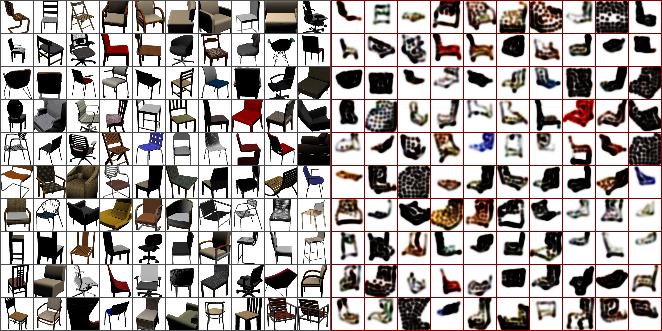

In [40]:
im1 = disp_grid(model.preprocess(data.X[0:100]), border=1, bordercolor=(.3, .3, .3))
im2 = disp_grid(reconstruct(model.preprocess(data.X[0:100])), border=1, bordercolor=(.5, 0, 0))
im_mix = np.empty((im1.shape[0], im1.shape[1] + im2.shape[1], 3))
im_mix[:, 0:im1.shape[1]] = im1
im_mix[:, im1.shape[1]:] = im2
imsave('im_mix.png', im_mix)
Image('im_mix.png')

## iterative refinement

In [41]:
nb_iter = 100
nb_examples = 100

np.random.seed(2)

imgs = np.empty((nb_examples, nb_iter + 1, c, w, h)) # 1 = color channel
imgs = imgs.astype(np.float32)

imgs[:, 0] = np.random.uniform(size=(nb_examples, c, w, h))

if c == 3:
    noise = np.random.normal(0, 0.5, size=imgs[:, 0].shape).astype(np.float32) #(for colored images)
else:
    noise = 0

def normalize(x, axis=1):
    return (x - x.min(axis=axis, keepdims=True)) / (x.max(axis=axis, keepdims=True) - x.min(axis=axis, keepdims=True))
    
ones = []

whitepx_ratio = (data.X>0.5).sum() / np.ones_like(data.X).sum()
#whitepx_ratio = 0.01
thresh = 'moving'

for i in tqdm(range(1, nb_iter + 1)):
    imgs[:, i] = reconstruct(imgs[:, i - 1] + noise)
    if c == 1:
        if thresh == 'moving':
            vals = imgs[:, i].flatten()
            vals = vals[np.argsort(vals)]
            thresh_ = vals[-int(whitepx_ratio * len(vals)) - 1]
        else:
            thresh_ = thresh
        imgs[:, i] = imgs[:, i] > thresh_ # binarize
        

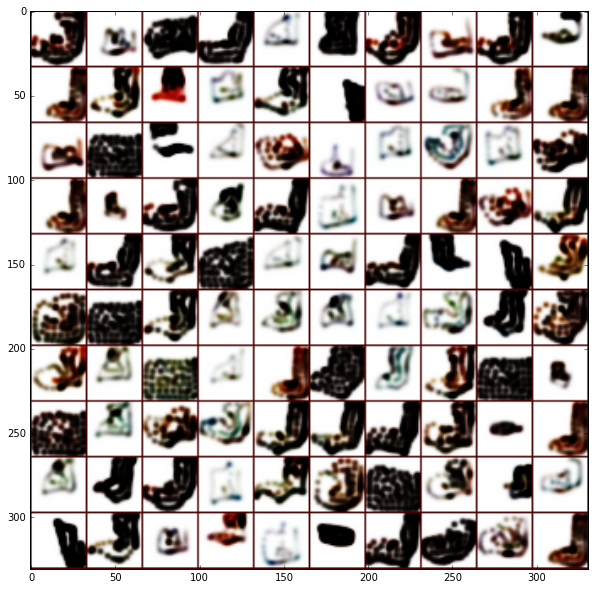

In [42]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(disp_grid(imgs[:, -1], border=1, bordercolor=(0.3, 0, 0))) # display last time step

In [43]:
seq_to_video(imgs, 'ir.mp4', border=0)
embed_video('ir.mp4')

/home/mcherti/miniconda/envs/databoard-env/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: /tmp/img_to_video6MqdLl/img00000000.png is a low contrast image
  warn('%s is a low contrast image' % fname)


ffmpeg -framerate 8 -i img%08d.png -c:v libx264 -r 8 -pix_fmt yuv420p /home/mcherti/work/code/feature_generation/ipynb/ir.mp4


## Feeding a new image

In [21]:
#dt_test = load_data('strokes', w=w,h=h) # for grayscale
#dt_test = load_data('digits', w=w, h=h)
dt_test = load_data('omniglot', w=w, h=h)

(128, 32, 32)


(100, 3, 32, 32)
0.0971448


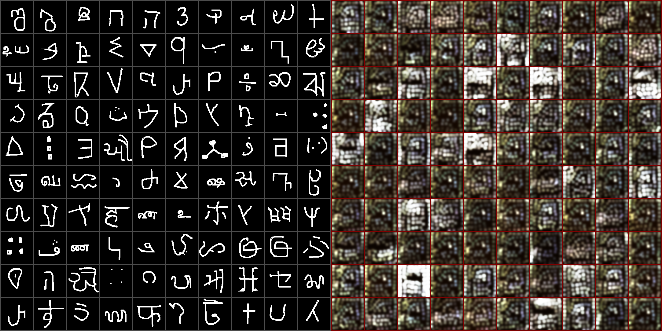

In [22]:

# load from file

nb = 100
dt = dt_test.X[0:nb]
try:
    dt = dt.reshape((nb, c, w, h))
except Exception:
    dt = dt.reshape((nb, 1, w, h))
    dt = dt * np.ones((1, 3, 1, 1))
    dt = dt.astype(np.float32)
print(dt.shape)
rec = reconstruct(dt)
print(((rec - dt)**2).mean())

im1 = disp_grid(model.preprocess(dt[0:nb]), border=1, bordercolor=(.3, .3, .3))
im2 = disp_grid(reconstruct(model.preprocess(rec[0:nb])), border=1, bordercolor=(.5, 0, 0))
im_mix = np.empty((im1.shape[0], im1.shape[1] + im2.shape[1], 3))
im_mix[:, 0:im1.shape[1]] = im1
im_mix[:, im1.shape[1]:] = im2
imsave('im_mix_new_dataset.png', im_mix)
Image('im_mix_new_dataset.png')